Let me retry this job and see if I can get a better MAE score than 6946.85

In [66]:
import pandas as pd
import numpy as np

import optuna
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("../data/Help Mr K The car thief/car_prices_train.csv")

In [5]:
df.head()

,Brand,Model,Model Year,Mileage,Fuel Type,Engine,Liter,Transmission,Speed,Exterior Color,Interior Color,Accident,Clean Title,Price
0,Ford,Utility Police Interceptor Base,2013,51000,E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,3.7,6-Speed A/T,6.0,Black,Black,At least 1 accident or damage reported,Yes,10300
1,Hyundai,Palisade SEL,2021,34742,Gasoline,3.8L V6 24V GDI DOHC,3.8,8-Speed Automatic,8.0,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,38005
2,Lexus,RX 350 RX 350,2022,22372,Gasoline,3.5 Liter DOHC,3.5,Automatic,NaN,Blue,Black,None reported,NaN,54598
3,INFINITI,Q50 Hybrid Sport,2015,88900,Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,3.5,7-Speed A/T,7.0,Black,Black,None reported,Yes,15500
4,Audi,Q3 45 S line Premium Plus,2021,9835,Gasoline,2.0L I4 16V GDI DOHC Turbo,2.0,8-Speed Automatic,8.0,Glacier White Metallic,Black,None reported,NaN,34999


Model and Engine have a lot of unique values. I don't think it should matter if they're removed because we can work by brand, year and liter

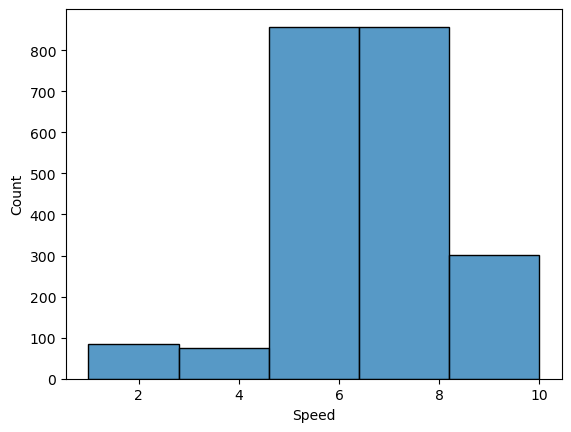

In [15]:
sns.histplot(data=df, x="Speed", bins=5);

In [16]:
df.drop(["Model", "Engine"], axis=1, inplace=True)
df.head()

,Brand,Model Year,Mileage,Fuel Type,Liter,Transmission,Speed,Exterior Color,Interior Color,Accident,Clean Title,Price
0,Ford,2013,51000,E85 Flex Fuel,3.7,6-Speed A/T,6.0,Black,Black,At least 1 accident or damage reported,Yes,10300
1,Hyundai,2021,34742,Gasoline,3.8,8-Speed Automatic,8.0,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,38005
2,Lexus,2022,22372,Gasoline,3.5,Automatic,NaN,Blue,Black,None reported,NaN,54598
3,INFINITI,2015,88900,Hybrid,3.5,7-Speed A/T,7.0,Black,Black,None reported,Yes,15500
4,Audi,2021,9835,Gasoline,2.0,8-Speed Automatic,8.0,Glacier White Metallic,Black,None reported,NaN,34999


In [17]:
df.isna().mean()

Brand             0.000000
Model Year        0.000000
Mileage           0.000000
Fuel Type         0.042405
Liter             0.059366
Transmission      0.000000
Speed             0.457221
Exterior Color    0.000000
Interior Color    0.000000
Accident          0.028187
Clean Title       0.148666
Price             0.000000
dtype: float64

In [24]:
for label, content in df.items():
    if content.isna().mean() > 0.01:
        print(f"{label}: {content.dtype}")

Fuel Type: object
Liter: float64
Speed: float64
Accident: object
Clean Title: object


These are the missing values and their dtype. Lets just start with a base Pipeline and use GridSearchCv to change values

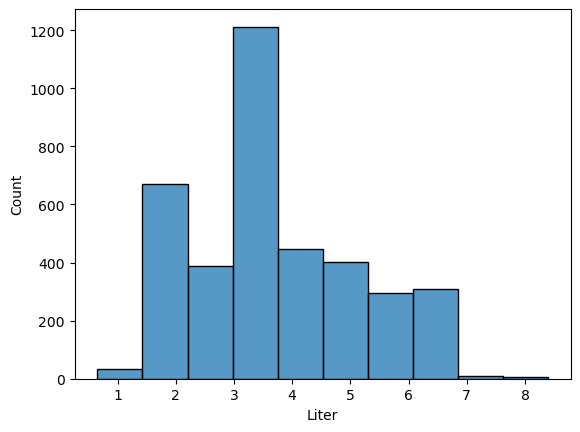

In [27]:
sns.histplot(data=df, x="Liter", bins=10);

In [28]:
cat_labels = [c for c in df if not pd.api.types.is_numeric_dtype(df[c])]
num_labels = [c for c in df if pd.api.types.is_numeric_dtype(df[c]) and c != "Price"]

In [56]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
])

In [57]:
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

In [58]:
preprocessor = ColumnTransformer([
    ("num_pipeline", num_pipeline, num_labels),
    ("cat_pipeline", cat_pipeline, cat_labels)
], remainder="passthrough")

In [59]:
X = df.drop("Price", axis=1)
y = df["Price"]

In [60]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((2806, 11), (2806,), (1203, 11), (1203,))

In [61]:
X_train_pre = preprocessor.fit_transform(X_train)
X_valid_pre = preprocessor.transform(X_valid)

In [62]:
regr = CatBoostRegressor(verbose=False)

In [63]:
regr.fit(X_train_pre, y_train, plot=True, verbose=False);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [64]:
y_preds = regr.predict(X_valid_pre)

In [65]:
mean_absolute_error(y_valid, y_preds)

10977.135995379249

In [80]:
gs_param = {
    "preprocessor__num_pipeline__imputer__strategy": ["mean", "median", "most_frequent"],
    "preprocessor__cat_pipeline__imputer__strategy": ["constant", "most_frequent"]
}

In [81]:
gs_regr = GridSearchCV(regr, gs_param, cv=5, n_jobs=-1)

In [82]:
gs_regr.fit(X_train_pre, y_train)

ValueError: 
All the 20 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Panache Branding\miniconda3\envs\catboost_env\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Panache Branding\miniconda3\envs\catboost_env\lib\site-packages\catboost\core.py", line 5827, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "C:\Users\Panache Branding\miniconda3\envs\catboost_env\lib\site-packages\catboost\core.py", line 2385, in _fit
    train_params = self._prepare_train_params(
  File "C:\Users\Panache Branding\miniconda3\envs\catboost_env\lib\site-packages\catboost\core.py", line 2311, in _prepare_train_params
    _check_train_params(params)
  File "_catboost.pyx", line 6393, in _catboost._check_train_params
  File "_catboost.pyx", line 6415, in _catboost._check_train_params
_catboost.CatBoostError: C:/Go_Agent/pipelines/BuildMaster/catboost.git/catboost/private/libs/options/plain_options_helper.cpp:512: Unknown option {preprocessor__num_pipeline__imputer__strategy} with value "mean"

--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Panache Branding\miniconda3\envs\catboost_env\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Panache Branding\miniconda3\envs\catboost_env\lib\site-packages\catboost\core.py", line 5827, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "C:\Users\Panache Branding\miniconda3\envs\catboost_env\lib\site-packages\catboost\core.py", line 2385, in _fit
    train_params = self._prepare_train_params(
  File "C:\Users\Panache Branding\miniconda3\envs\catboost_env\lib\site-packages\catboost\core.py", line 2311, in _prepare_train_params
    _check_train_params(params)
  File "_catboost.pyx", line 6393, in _catboost._check_train_params
  File "_catboost.pyx", line 6415, in _catboost._check_train_params
_catboost.CatBoostError: C:/Go_Agent/pipelines/BuildMaster/catboost.git/catboost/private/libs/options/plain_options_helper.cpp:512: Unknown option {preprocessor__num_pipeline__imputer__strategy} with value "median"
